In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from numpy.random import Generator, PCG64

## Noise Induced Bifurcations

For today problem we will start to look to the noise induced bifurcations. We will try to simulate a bit a particular problem but we will performed before a qualitative analysis. The problem we will treat today is known as **harvest process** and it's a small variant of the logistic problem seen in Lecture 3.

**PROBLEM**: Let's consider a forest in which we have a normalized, upon the logistic carry value, amount of biomass $x$. The forest grows or shrinks accordingly to the logistic law. However this forest is not so uncontaminated by the human presence and some companies conducts lumberjack activities in the region cutting of a certain percentage of trees. So the equation for our deterministic problem is given by:

$$
\frac{dx}{dt}=a_0\left(x(1-x)\right)-kx
$$

where $\alpha$ is a reinforcement parameter for the growth and $k$ is the intensity of the deforestation activities. We are still missing something: the growth capability of the forest is not fixed in time but have a perturbation so $a_0\rightarrow a_0+s\xi(t)$. So our equation become:

$$
\frac{dx}{dt}=a_0\left(x(1-x)\right)-kx+s(x(1-x))\xi(t)
$$

**REQUEST**: Model this problem and define the usual features (probability projections, trajs,...) and analyze the probability distribution looking for the bifurcations.

### Step 1: a bit of qualitative analysis

Doing qualitative analysis in the SDS it's not easier as for their deterministic counterparts but we can try to work a bit. Please eyes up to the blackboard. 

### Step 2: Constructing the class and first checks

After this qualitative analysis we can start to build the class for our problem. We will recycle the code used in Lecture 3 adjusting the different parts:

In [2]:
#We need to change the function, the class vars and the stochastic formula

class Harvest(object):
    '''
    This function will simulate trajectories for an initialize
    perturbed logistic system
    '''

    #CONSTRUCTOR
    def __init__(self,a0: float,k: float,s:float)->None:
        self.a0 = a0
        self.k = k
        self.s = s

        if(a0<=0 or k<=0 or s<=0):
            raise RuntimeError("One of the given parameter is 0 or negative")
        
        return

    def __checkInputs(self,x0: float,T: float,N: int)->None:
        '''
        Given the inputs for a trajectory, this method will
        check if they are correct
        '''
        #x0 checks:
        if x0<0:
            raise RuntimeError("Initial population must be positive")

        #T checks:
        if T<0:
            raise RuntimeError("Time interval must have a positive lenght")

        #N checks:
        if N<=1:
            raise RuntimeError("The simulation must have at least two steps")

        return

    def __RK4(self,t_n: float,y_n: float,h: float)->float: 
        '''
        Given a point in the trajectory, the time instant and the step lenght,
        this method will compute the variation for y using the RK4 for the 
        deterministic part of the PLS
        '''
        #Perform the check of the inputs. For N we hard code a good 
        self.__checkInputs(y_n,t_n,10)
        
        if h<=0:
            raise RuntimeError("Given h is negative or 0")

        f = lambda x: self.a0*x*(1-x)-self.k*x
        
        k_1 = f(y_n)
        k_2 = f(y_n+h*k_1/2)
        k_3 = f(y_n+h*k_2/2)
        k_4 = f(y_n+h*k_3)

        return h*(k_1+2*k_2+2*k_3+k_4)/6
        
        
    
    def simulateTraj(self,x0: float,T: float,N: int): 
        '''
        Given the initial population value x0, the considered interval lenght T
        and the number of step in the computation N, this method will return a
        trajectory for the PLS.
        '''
        #Check the inputs
        self.__checkInputs(x0,T,N)

        if T==0:
            return np.array([x0])

        #Setup step lenght and traj array
        h = T/N
        traj = np.zeros(N+1,dtype=float)
        traj[0] = x0
        time = np.zeros(N+1,dtype=float)
        time[0] = 0.0

        #Setup random generator
        rng = Generator(PCG64())

        for i in range(1,N+1):
            time[i] = i*h
            dx = self.__RK4(time[i-1],traj[i-1],h) #determinstic part
            dx += self.s*traj[i-1]*(1.0-traj[i-1])*rng.normal()*np.sqrt(h) #noise part
            traj[i] = traj[i-1] + dx
            if traj[i]<0: traj[i]=0.0

        return traj,time

We will try using the following parameters a0=1.0, k=0.3. For now let's pose s=0.25 (so, according to the explanation) we should have an attractive in-domain point and 0 repulsive point.

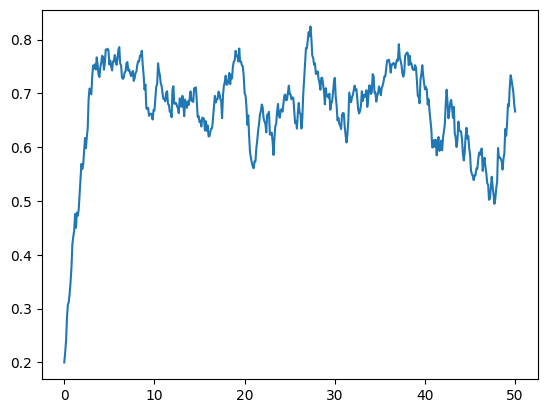

In [3]:
system = Harvest(1.0,0.3,0.25)

tr1, time1 = system.simulateTraj(0.2,50,500)
plt.plot(time1,tr1)

To check that all works properly let's also produce the probability distribution for a bunch of trajectories

In [4]:
omega = [0.0,1.0] #0,100
Nbins = 150 #100
Nsim = 10000 #10000
m = (omega[1]-omega[0])/Nbins
system = Harvest(1.0,0.3,0.25)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),50,500)
    for i in range(Nbins):
        if ptraj[-1] < (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break

bins = bins/(Nsim*m)

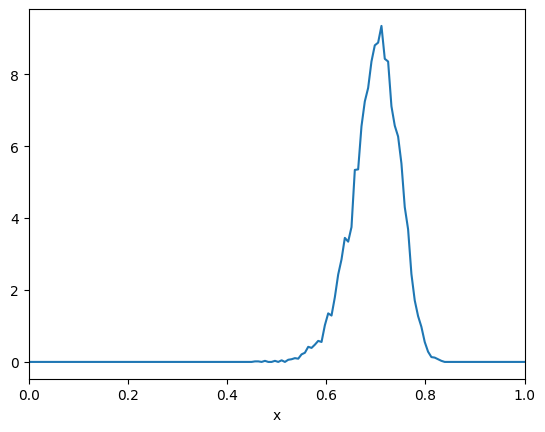

In [5]:
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.xlim(0.0,1.0)
plt.plot(x,bins)

### Step 3: Looking to other values for the noise

Now we can start to analyze the problem to try to see if our predictions where correct. Looking to the previous relationship the bifurcation should be at

$$
s=\sqrt{a_0-k}\approx 0.84
$$

In [ ]:
omega = [0.0,1.0] #0,100
Nbins = 150 #100
Nsim = 10000 #10000
m = (omega[1]-omega[0])/Nbins
system = Harvest(1.0,0.3,0.75)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),50,500)
    for i in range(Nbins):
        if ptraj[-1] < (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break

bins = bins/(Nsim*m)

In [ ]:
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.xlim(0.0,1.0)
plt.plot(x,bins)

In [6]:
omega = [0.0,1.0] #0,100
Nbins = 150 #100
Nsim = 10000 #10000
m = (omega[1]-omega[0])/Nbins
system = Harvest(1.0,0.3,0.95)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),50,500)
    for i in range(Nbins):
        if ptraj[-1] < (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break

bins = bins/(Nsim*m)

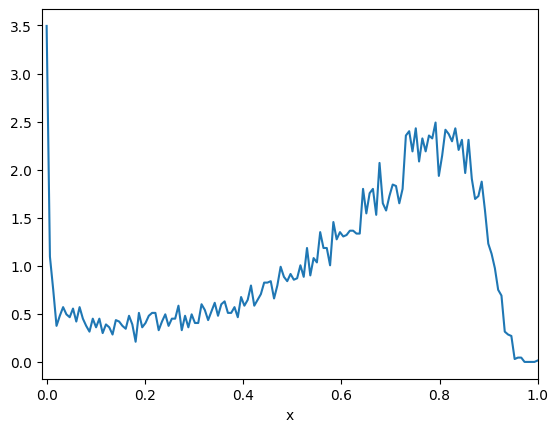

In [9]:
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.xlim(-0.01,1.0)
plt.plot(x,bins)

We have found the two behaviours and the bigfurcation found previously by qualitative analysis!

### Step 4: FIN... Waiiiit a minute...

<img src="wait_a_minute.jpg" alt="drawing" width="200"/>

Ok, this is all nice and beautiful but one can make some observations and argue some aspects of our analysis:

- Firstly, potentially $s$ has no upper limite. We can suppose to have enormous flutuations. We have only studied the behaviour of the fluctuations moving from $s=0$ to the bifucartion but for bigger values will there be others? During our analysis we said also that for growing $s$ the unstable point (the minimum between the two peaks above) moves towards 1. Let's try to check this property first at least: 

In [14]:
omega = [0.0,1.0] #0,100
Nbins = 150 #100
Nsim = 10000 #10000
m = (omega[1]-omega[0])/Nbins
system = Harvest(1.0,0.3,1.05)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),50,500)
    for i in range(Nbins):
        if ptraj[-1] < (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break

bins = bins/(Nsim*m)

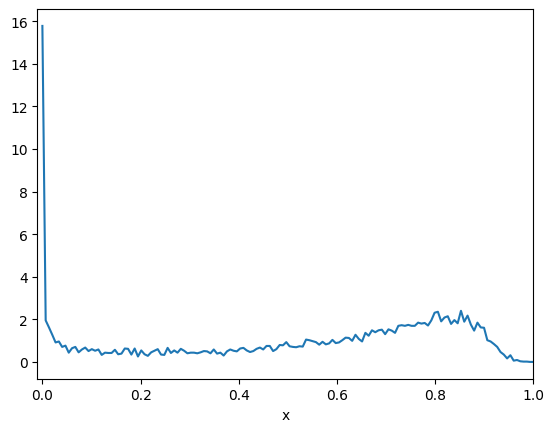

In [15]:
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.xlim(-0.01,1.0)
plt.plot(x,bins)

- Ok, this property seems correctly predicted. However what will happend for greater $s$? And even if we are able to find a bifurcation how we can be sure generally that is the last one?

- Secondly, this behaviour has been observed for a fixed combination of $a0$ and $k$. Obviously we can imagine that exists a neighbourhood where this behaviour persist but can we be sure that chaing this parameters the behaviours will conserve? We have also to consider the fact that in a SDS there are still the old deterministic bifurcations and this can have a strong influence on the stochastic behvaiour itself!

The answer of all of these questions will be given in the following lectures.